In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import*
from scipy import ndimage as ndi
import napari
from skimage.morphology import*
from skimage.segmentation import*
from skimage.measure import*
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import*
from matplotlib.figure import*
import pandas as pd
import os
from skimage.filters import median
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from sklearn.metrics import r2_score
import pandas as pd
import warnings; warnings.simplefilter('ignore')
sns.set_style('ticks')

In [2]:
img = imread('x63_0-25um_BeadCroppedDemo.tif')
print(img.shape)

(101, 480, 480, 4)


Image viz

In [26]:
img = ndi.median_filter(img, size=3)
mean_pix = img.mean()
std_pix = img.std()
thresh = mean_pix + (std_pix*10)

In [27]:
#split all the channel create a single images
sp_img = []
for i in range(img.shape[0]):
    for j in range(img.shape[3]):
        sp_img.append(img[i,:,:,j])

sp_img = np.array(sp_img)
print(sp_img.shape)

(404, 480, 480)


In [193]:
frame_idx = np.random.permutation(range(sp_img.shape[0]))[0]
slice_idx = sp_img[frame_idx]
thresh_idx = slice_idx > thresh

(-0.5, 479.5, 479.5, -0.5)

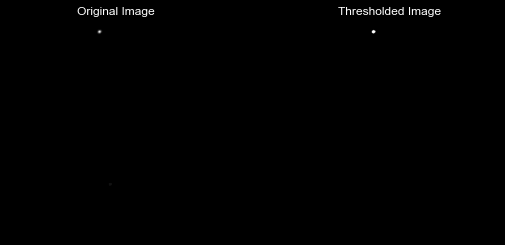

In [194]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,4))
ax1.imshow(slice_idx,cmap='gray')
ax1.set_title('Original Image')
ax2.imshow(thresh_idx,cmap='gray')
ax2.set_title('Thresholded Image')
ax1.axis('off')
ax2.axis('off')

(-0.5, 479.5, 479.5, -0.5)

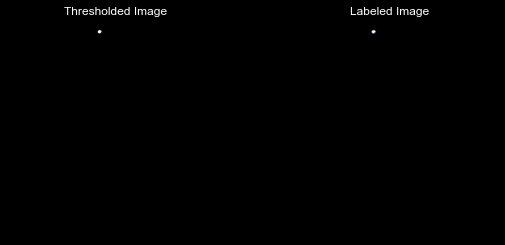

In [195]:
slice_label = label(thresh_idx)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,4))
ax1.imshow(thresh_idx,cmap='gray')
ax1.set_title('Thresholded Image')
ax2.imshow(slice_label,cmap=plt.cm.gist_earth)
ax2.set_title('Labeled Image')
ax1.axis('off')
ax2.axis('off')

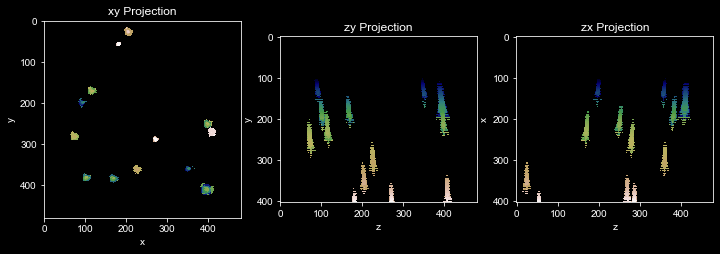

In [179]:
#Max projections
%matplotlib inline
plt.style.use('dark_background')
vol_label = label(sp_img)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 4))
for i, (cax, clabel) in enumerate(zip([ax1, ax2, ax3], ['xy', 'zy', 'zx'])):
    cax.imshow(np.max(vol_label,i).squeeze(), interpolation='none', cmap = plt.cm.gist_earth)
    cax.set_title('%s Projection' % clabel)
    cax.set_xlabel(clabel[0])
    cax.set_ylabel(clabel[1])

In [200]:
vert_frame = np.random.permutation(range(vol_label.shape[1]))[0]
vert_slice = sp_img[:,vert_frame,:]
vert_thresh = vert_slice > thresh

(-0.5, 479.5, 403.5, -0.5)

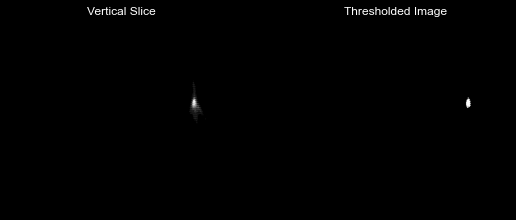

In [201]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,4))
ax1.imshow(vert_slice,cmap='gray')
ax1.set_title('Vertical Slice')
ax2.imshow(vert_thresh,cmap='gray')
ax2.set_title('Thresholded Image')
ax1.axis('off')
ax2.axis('off')

In [3]:
#read the icy spot detection csv for each channels. Always remember indexing start from 0
ch0 = pd.read_excel('ch0.xls')
ch1 = pd.read_excel('ch1.xls')
ch2 = pd.read_excel('ch2.xls')
ch3 = pd.read_excel('ch3.xls')

In [4]:
#exploring the data
ch0.head(5)

,Name,Position X,Position Y,Position Z,Position T,Size Y,Size Z,Center X,Center Y,Center Z,Center T
0,spot #0,180.0,56.0,100.0,0.0,2.0,1.0,180.500000,56.500000,100.000000,0.0
1,spot #1,269.0,286.0,96.0,0.0,5.0,4.0,271.032787,288.000000,97.524590,0.0
2,spot #2,405.0,269.0,91.0,0.0,5.0,5.0,406.760000,270.733333,92.866667,0.0
3,spot #3,202.0,24.0,84.0,0.0,5.0,5.0,203.761194,25.955224,86.194030,0.0
4,spot #4,223.0,360.0,72.0,0.0,5.0,5.0,225.241379,361.793103,73.862069,0.0


In [5]:
#grab the centroid coordinates
centroids_0 = ch0.iloc[:,7:10].values
centroids_1 = ch1.iloc[:,7:10].values
centroids_2 = ch2.iloc[:,7:10].values
centroids_3 = ch3.iloc[:,7:10].values

In [6]:
#get the last only the Center Z values for each channel
centroids_0_z = centroids_0[:,2]
centroids_1_z = centroids_1[:,2]
centroids_2_z = centroids_2[:,2]
centroids_3_z = centroids_3[:,2]

In [7]:
#get the last only the Center X values for each channel
centroids_0_x = centroids_0[:,0]
centroids_1_x = centroids_1[:,0]
centroids_2_x = centroids_2[:,0]
centroids_3_x = centroids_3[:,0]

#get the last only the Center Y values for each channel
centroids_0_y = centroids_0[:,1]
centroids_1_y = centroids_1[:,1]
centroids_2_y = centroids_2[:,1]
centroids_3_y = centroids_3[:,1]

In [8]:
#difference between the z-coordinates of the centroids with respect to channel 0
diff_z_0_1 = centroids_0_z - centroids_1_z
diff_z_0_2 = centroids_0_z - centroids_2_z
diff_z_0_3 = centroids_0_z - centroids_3_z

#difference between the z-coordinates of the centroids with respect to channel 1
diff_z_1_2 = centroids_1_z - centroids_2_z
diff_z_1_3 = centroids_1_z - centroids_3_z
diff_z_1_0 = centroids_1_z - centroids_0_z

#difference between the z-coordinates of the centroids with respect to channel 2
diff_z_2_3 = centroids_2_z - centroids_3_z
diff_z_2_0 = centroids_2_z - centroids_0_z
diff_z_2_1 = centroids_2_z - centroids_1_z

#difference between the z-coordinates of the centroids with respect to channel 3
diff_z_3_0 = centroids_3_z - centroids_0_z
diff_z_3_1 = centroids_3_z - centroids_1_z
diff_z_3_2 = centroids_3_z - centroids_2_z

In [9]:
#reshape the z-coordinates for regression
z_0_reshaped = centroids_0_z.reshape(-1,1)
z_1_reshaped = centroids_1_z.reshape(-1,1)
z_2_reshaped = centroids_2_z.reshape(-1,1)
z_3_reshaped = centroids_3_z.reshape(-1,1)

In [10]:
#Linear regressions wrt channel 0
reg_0_1 = LinearRegression().fit(z_0_reshaped,diff_z_0_1)
reg_0_2 = LinearRegression().fit(z_0_reshaped,diff_z_0_2)
reg_0_3 = LinearRegression().fit(z_0_reshaped,diff_z_0_3)

#Linear regressions wrt channel 1
reg_1_2 = LinearRegression().fit(z_1_reshaped,diff_z_1_2)
reg_1_3 = LinearRegression().fit(z_1_reshaped,diff_z_1_3)
reg_1_0 = LinearRegression().fit(z_1_reshaped,diff_z_1_0)

#Linear regressions wrt channel 2
reg_2_3 = LinearRegression().fit(z_2_reshaped,diff_z_2_3)
reg_2_0 = LinearRegression().fit(z_2_reshaped,diff_z_2_0)
reg_2_1 = LinearRegression().fit(z_2_reshaped,diff_z_2_1)

#Linear regressions wrt channel 3
reg_3_0 = LinearRegression().fit(z_3_reshaped,diff_z_3_0)
reg_3_1 = LinearRegression().fit(z_3_reshaped,diff_z_3_1)
reg_3_2 = LinearRegression().fit(z_3_reshaped,diff_z_3_2)

In [11]:
#get m-values for each regression channel
m0 = reg_0_1.coef_.tolist()+reg_0_2.coef_.tolist()+reg_0_3.coef_.tolist()
m1 = reg_1_2.coef_.tolist()+reg_1_3.coef_.tolist()+reg_1_0.coef_.tolist()
m2 = reg_2_3.coef_.tolist()+reg_2_0.coef_.tolist()+reg_2_1.coef_.tolist()
m3 = reg_3_0.coef_.tolist()+reg_3_1.coef_.tolist()+reg_3_2.coef_.tolist()

#get the c-values for each regression channel
c0 = [reg_0_1.intercept_,reg_0_2.intercept_,reg_0_3.intercept_]
c1 = [reg_1_2.intercept_,reg_1_3.intercept_,reg_1_0.intercept_]
c2 = [reg_2_3.intercept_,reg_2_0.intercept_,reg_2_1.intercept_]
c3 = [reg_3_0.intercept_,reg_3_1.intercept_,reg_3_2.intercept_]

In [12]:
#create a dataframe with the m-values and c-values
reg_vals = pd.DataFrame({'m0':m0,'m1':m1,'m2':m2,'m3':m3,'c0':c0,'c1':c1,'c2':c2,'c3':c3})

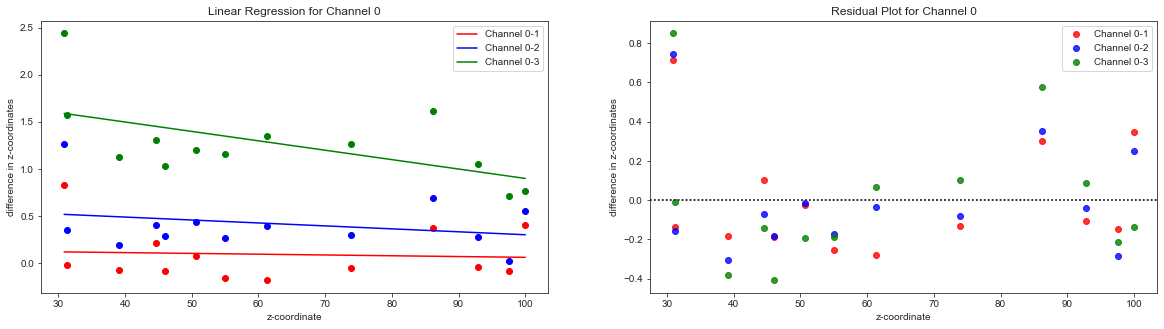

In [14]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)

ax1 = plt.scatter(centroids_0_z,diff_z_0_1,c='r')
ax1 = plt.plot(centroids_0_z,reg_0_1.predict(z_0_reshaped),c='r',label='Channel 0-1')
ax1 = plt.scatter(centroids_0_z,diff_z_0_2,c='b')
ax1 = plt.plot(centroids_0_z,reg_0_2.predict(z_0_reshaped),c='b',label='Channel 0-2')
ax1 = plt.scatter(centroids_0_z,diff_z_0_3,c='g')
ax1 = plt.plot(centroids_0_z,reg_0_3.predict(z_0_reshaped),c='g',label='Channel 0-3')
ax1 = plt.xlabel('z-coordinate')
ax1 = plt.ylabel('difference in z-coordinates')
ax1 = plt.title('Linear Regression for Channel 0')
ax1 = plt.legend()

ax2 = fig.add_subplot(122)
ax2 = sns.residplot(centroids_0_z,diff_z_0_1,data=reg_0_1.predict(z_0_reshaped),ax=ax2,color='r',label='Channel 0-1')
ax2 = sns.residplot(centroids_0_z,diff_z_0_2,data=reg_0_2.predict(z_0_reshaped),ax=ax2,color='b',label='Channel 0-2')
ax2 = sns.residplot(centroids_0_z,diff_z_0_3,data=reg_0_3.predict(z_0_reshaped),ax=ax2,color='g',label='Channel 0-3')
ax2 = plt.xlabel('z-coordinate')
ax2 = plt.ylabel('difference in z-coordinates')
ax2 = plt.title('Residual Plot for Channel 0')
ax2 = plt.legend()

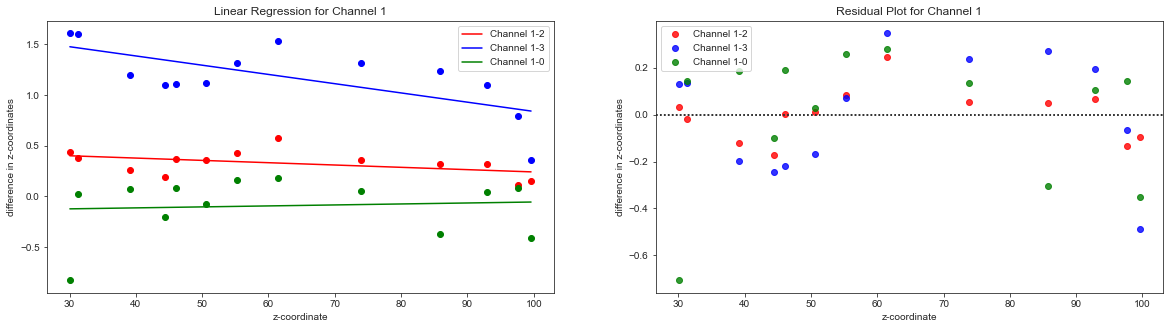

In [15]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax1 = plt.scatter(centroids_1_z,diff_z_1_2,c='r')
ax1 = plt.plot(centroids_1_z,reg_1_2.predict(z_1_reshaped),c='r',label='Channel 1-2')
ax1 = plt.scatter(centroids_1_z,diff_z_1_3,c='b')
ax1 = plt.plot(centroids_1_z,reg_1_3.predict(z_1_reshaped),c='b',label='Channel 1-3')
ax1 = plt.scatter(centroids_1_z,diff_z_1_0,c='g')
ax1 = plt.plot(centroids_1_z,reg_1_0.predict(z_1_reshaped),c='g',label='Channel 1-0')
ax1 = plt.xlabel('z-coordinate')
ax1 = plt.ylabel('difference in z-coordinates')
ax1 = plt.title('Linear Regression for Channel 1')
ax1 = plt.legend()

ax2 = fig.add_subplot(122)
ax2 = sns.residplot(centroids_1_z,diff_z_1_2,data=reg_1_2.predict(z_1_reshaped),ax=ax2,color='r',label='Channel 1-2')
ax2 = sns.residplot(centroids_1_z,diff_z_1_3,data=reg_1_3.predict(z_1_reshaped),ax=ax2,color='b',label='Channel 1-3')
ax2 = sns.residplot(centroids_1_z,diff_z_1_0,data=reg_1_0.predict(z_1_reshaped),ax=ax2,color='g',label='Channel 1-0')
ax2 = plt.xlabel('z-coordinate')
ax2 = plt.ylabel('difference in z-coordinates')
ax2 = plt.title('Residual Plot for Channel 1')
ax2 = plt.legend()

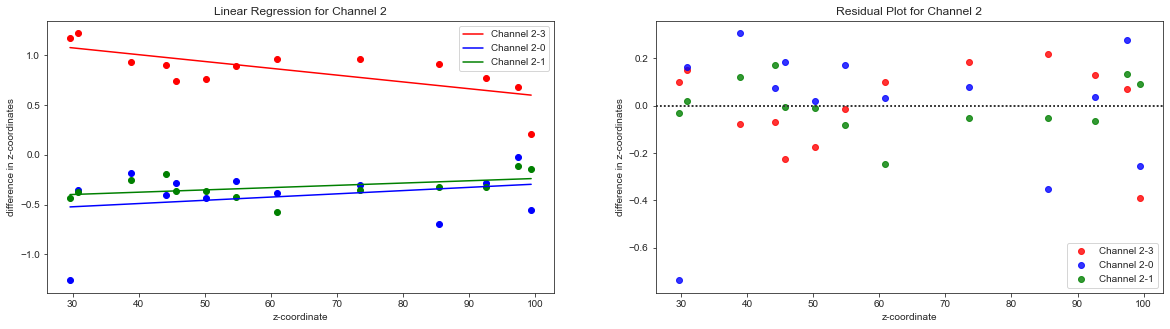

In [16]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax1 = plt.scatter(centroids_2_z,diff_z_2_3,c='r')
ax1 = plt.plot(centroids_2_z,reg_2_3.predict(z_2_reshaped),c='r',label='Channel 2-3')
ax1 = plt.scatter(centroids_2_z,diff_z_2_0,c='b')
ax1 = plt.plot(centroids_2_z,reg_2_0.predict(z_2_reshaped),c='b',label='Channel 2-0')
ax1 = plt.scatter(centroids_2_z,diff_z_2_1,c='g')
ax1 = plt.plot(centroids_2_z,reg_2_1.predict(z_2_reshaped),c='g',label='Channel 2-1')
ax1 = plt.xlabel('z-coordinate')
ax1 = plt.ylabel('difference in z-coordinates')
ax1 = plt.title('Linear Regression for Channel 2')
ax1 = plt.legend()

ax2 = fig.add_subplot(122)
ax2 = sns.residplot(centroids_2_z,diff_z_2_3,data=reg_2_3.predict(z_2_reshaped),ax=ax2,color='r',label='Channel 2-3')
ax2 = sns.residplot(centroids_2_z,diff_z_2_0,data=reg_2_0.predict(z_2_reshaped),ax=ax2,color='b',label='Channel 2-0')
ax2 = sns.residplot(centroids_2_z,diff_z_2_1,data=reg_2_1.predict(z_2_reshaped),ax=ax2,color='g',label='Channel 2-1')
ax2 = plt.xlabel('z-coordinate')
ax2 = plt.ylabel('difference in z-coordinates')
ax2 = plt.title('Residual Plot for Channel 2')
ax2 = plt.legend()

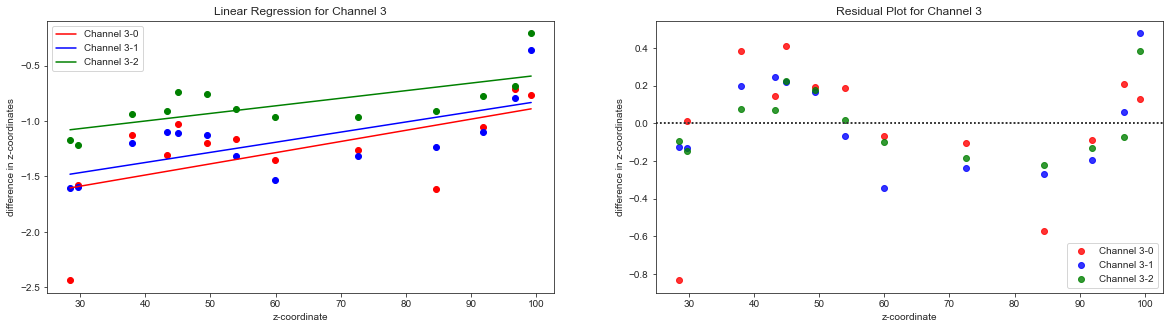

In [17]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax1 = plt.scatter(centroids_3_z,diff_z_3_0,c='r')
ax1 = plt.plot(centroids_3_z,reg_3_0.predict(z_3_reshaped),c='r',label='Channel 3-0')
ax1 = plt.scatter(centroids_3_z,diff_z_3_1,c='b')
ax1 = plt.plot(centroids_3_z,reg_3_1.predict(z_3_reshaped),c='b',label='Channel 3-1')
ax1 = plt.scatter(centroids_3_z,diff_z_3_2,c='g')
ax1 = plt.plot(centroids_3_z,reg_3_2.predict(z_3_reshaped),c='g',label='Channel 3-2')
ax1 = plt.xlabel('z-coordinate')
ax1 = plt.ylabel('difference in z-coordinates')
ax1 = plt.title('Linear Regression for Channel 3')
ax1 = plt.legend()

ax2 = fig.add_subplot(122)
ax2 = sns.residplot(centroids_3_z,diff_z_3_0,data=reg_3_0.predict(z_3_reshaped),ax=ax2,color='r',label='Channel 3-0')
ax2 = sns.residplot(centroids_3_z,diff_z_3_1,data=reg_3_1.predict(z_3_reshaped),ax=ax2,color='b',label='Channel 3-1')
ax2 = sns.residplot(centroids_3_z,diff_z_3_2,data=reg_3_2.predict(z_3_reshaped),ax=ax2,color='g',label='Channel 3-2')
ax2 = plt.xlabel('z-coordinate')
ax2 = plt.ylabel('difference in z-coordinates')
ax2 = plt.title('Residual Plot for Channel 3')
ax2 = plt.legend()

In [18]:
#save reg_vals to file, optional if you want to use them later
#reg_coefs = reg_vals.to_csv('reg_coefs.csv',index=False)

In [19]:
mvals = reg_vals.loc[:,'m0':'m3'].stack().to_list()
cvals = reg_vals.loc[:,'c0':'c3'].stack().to_list()

In [216]:
reg_vals.head()

,m0,m1,m2,m3,c0,c1,c2,c3
0,-0.000834,-0.002282,-0.006839,0.010080,0.145089,0.468137,1.279034,-1.890243
1,-0.003128,-0.009124,0.003252,0.009137,0.614146,1.749559,-0.620498,-1.739564
2,-0.009980,0.000966,0.002297,0.006843,1.896890,-0.153241,-0.468291,-1.273415


In [217]:
#keeping channel 0 as base and correcting wrt to that
mvals_ch0 = reg_0_1.coef_[0].tolist(),reg_0_2.coef_[0].tolist(),reg_0_3.coef_[0].tolist()
cvals_ch0 = reg_0_1.intercept_,reg_0_2.intercept_,reg_0_3.intercept_

In [218]:
scale = np.array(img[:,:,:,0]).shape
zstart = 0
zrange_um = np.linspace(zstart,zstart+(img.shape[0]-1)*scale[0],img.shape[0])

In [219]:
Zshifts = []
for i in range(img.shape[3]-1):
    Zshifts.append((zrange_um*mvals[i])+cvals[i]+zstart)
Zshifts = np.array(Zshifts)

In [220]:
minzrange = Zshifts.min()
maxzrange = Zshifts.max()
rangesize  = maxzrange-minzrange

range2 = np.arange(zstart,zstart+rangesize+scale[0])

In [221]:
Zshifts2 = []
for i in range(img.shape[3]-1):
    Zshifts2.append((range2*mvals[i])+cvals[i])
Zshifts2 = np.array(Zshifts2)

In [223]:
zshifts_vx = np.round(Zshifts2/scale[0]).astype(int)
evpoint = Zshifts2.max()
cZshifts = zshifts_vx - evpoint
Nplanes = cZshifts.shape[1]

In [224]:
img_corr = []
Zplns = []
for i in range(Nplanes):
    for j in range(img.shape[3]-1):
       Zplns.append(cZshifts[j,i])

Zplns = np.array(Zplns)

In [225]:
for i in range(Zplns.shape[0]):
    for j in range(img.shape[3]-1):
        if i >=0 and i<=img.shape[0]-1:
            img_corr.append(img[i,:,:,j])

img_corr = np.array(img_corr)

In [227]:
img_corr.shape  #now its giving less frames than the original

(303, 480, 480)